In [ ]:
import numpy as np, random, math, time, matplotlib.pyplot as plt, pandas as pd
from math import log2
random.seed(42); np.random.seed(42)

In [ ]:
def compute_channel_gain(distance):
    return 1.0 / (distance ** 4) if distance > 0 else 1.0

def shannon_rate(W, TP, Gk, sigma2):
    arg = 1.0 + max(0.0, (TP * Gk / max(sigma2, 1e-30)))
    return W * math.log2(arg)

system_params = {
    "C": 1e-28,
    "TP": 0.5,
    "RP": 0.1,
    "sigma2": 1e-26,
    "Flocal": 0.5e9,
    "FMEC": [5e9, 6e9, 7e9, 10e9],
    "Fcloud": 20e9,
    "W": 0.5e6,
    "distances_mec": [10,15,20,25],
    "cloud_distance": 100e3,
    "backhaul_speed": 2e8,
    "MEC_cost": [0.01,0.02,0.03,0.05],
    "Cloud_cost": 0.09,
    "beta": 1.0,
    "propagation_delay_cloud": None
}

In [ ]:
def compute_metrics_for_agent(agent, successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M):
    N = len(successors)
    PL_total = M + 2
    task_order = [int(x) for x in agent[:N]]
    locs = [int(x) for x in agent[N:2*N]]
    finish_time_by_task = {t: 0.0 for t in successors}
    per_task = {}
    Gk_list = [compute_channel_gain(d) for d in sys_params["distances_mec"]]
    if sys_params.get("propagation_delay_cloud") is not None:
        T_prop = sys_params["propagation_delay_cloud"]
    else:
        T_prop = sys_params["cloud_distance"] / sys_params["backhaul_speed"]
    for pos, task in enumerate(task_order):
        task = int(task)
        loc = locs[pos] if pos < len(locs) else 0
        if loc == 0:
            F = sys_params["Flocal"]
            cost_rate = 0.0
        elif 1 <= loc <= M:
            F = sys_params["FMEC"][loc - 1]
            cost_rate = sys_params["MEC_cost"][loc - 1]
        else:
            F = sys_params["Fcloud"]
            cost_rate = sys_params["Cloud_cost"]
        F_Hz = F
        ET = CC_cycles[task] / F_Hz
        T_trans = 0.0; T_rec = 0.0; TE = 0.0; RE = 0.0
        if loc != 0:
            mk = min(max(loc - 1, 0), len(Gk_list) - 1)
            Gk = Gk_list[mk]
            Rk = shannon_rate(sys_params["W"], sys_params["TP"], Gk, sys_params["sigma2"])
            Qin_bits = Qin_MB[task] * 8e6
            Qout_bits = Qout_MB[task] * 8e6
            T_trans = Qin_bits / max(Rk, 1e-9)
            T_rec = Qout_bits / max(Rk, 1e-9)
            TE = sys_params["TP"] * T_trans
            RE = sys_params["RP"] * T_rec
            if loc == M + 1:
                T_trans += T_prop; T_rec += T_prop
        preds = [p for p, succs in successors.items() if task in succs]
        WT = max([finish_time_by_task[p] for p in preds]) if preds else 0.0
        start_time = WT
        finish_time = start_time + T_trans + ET + T_rec
        finish_time_by_task[task] = finish_time
        E_local = 0.0
        if loc == 0:
            E_local = sys_params["C"] * CC_cycles[task] * (sys_params["Flocal"] ** 2)
        E_remote = TE + RE
        E_total = E_local + E_remote
        UC = sys_params["beta"] * E_remote if loc != 0 else 0.0
        per_task[task] = {"location_idx": loc, "start_time": start_time, "finish_time": finish_time,
                          "ET": ET, "T_trans": T_trans, "T_rec": T_rec,
                          "E_local": E_local, "E_remote": E_remote, "E_total": E_total, "UC": UC}
    L_total = max([info["finish_time"] for info in per_task.values()]) if per_task else 0.0
    E_total = sum([info["E_total"] for info in per_task.values()])
    UC_total = sum([info["UC"] for info in per_task.values()])
    a1,a2,a3 = (0.33,0.33,0.34)
    Z = a1 * L_total + a2 * E_total + a3 * UC_total
    return L_total, E_total, UC_total, Z, per_task

In [ ]:
def TLRS_normalize(task_cont_values, successors):
    N = len(successors)
    vals = {t: float(task_cont_values[i % len(task_cont_values)]) for i, t in enumerate(successors.keys())}
    in_deg = {t: 0 for t in successors}
    for u, succs in successors.items():
        for v in succs: in_deg[v] += 1
    ready = [t for t,d in in_deg.items() if d==0]
    order = []
    while ready:
        ready.sort(key=lambda x: vals[x], reverse=True)
        u = ready.pop(0); order.append(u)
        for v in successors[u]:
            in_deg[v] -= 1
            if in_deg[v]==0: ready.append(v)
    for t in successors:
        if t not in order: order.append(t)
    return order

def linear_scale_locations(vec, PL_total):
    arr = np.array(vec, dtype=float); mn,mx = float(arr.min()), float(arr.max())
    if abs(mx-mn) < 1e-12:
        return [random.randint(0, PL_total-1) for _ in arr]
    norm = (arr - mn) / (mx - mn)
    idx = np.round(norm * (PL_total - 1)).astype(int); idx = np.clip(idx,0,PL_total-1)
    return idx.tolist()

def continuous_to_agent(vec_cont, successors, PL_total):
    N = len(successors)
    if len(vec_cont) < 2*N: vec_cont = np.pad(vec_cont, (0,2*N-len(vec_cont)), 'wrap')
    task_cont = vec_cont[:N]; loc_cont = vec_cont[N:2*N]
    task_order = TLRS_normalize(task_cont, successors)
    loc_indices = linear_scale_locations(loc_cont, PL_total)
    agent = np.array(list(task_order) + loc_indices[:N], dtype=int)
    return agent

def WOA_update_population(pop_cont, best_cont, a):
    pop_new = pop_cont.copy(); pop_size = pop_cont.shape[0]
    for i in range(pop_size):
        X = pop_cont[i].copy(); r = random.random(); A = 2*a*r - a; C = 2*r; p = random.random()
        if p < 0.5 and abs(A) >= 1:
            Xr = pop_cont[random.randint(0,pop_size-1)]; D = np.abs(C*Xr - X); X_new = Xr - A*D
        elif p < 0.5 and abs(A) < 1:
            X_best = best_cont if best_cont is not None else pop_cont[random.randint(0,pop_size-1)]; D = np.abs(C*X_best - X); X_new = X_best - A*D
        else:
            X_best = best_cont if best_cont is not None else pop_cont[random.randint(0,pop_size-1)]; Dp = np.abs(X_best - X); b=1.0; Ls = random.uniform(-1,1); X_new = Dp * np.exp(b*Ls) * np.cos(2*math.pi*Ls) * X_best
        pop_new[i] = np.nan_to_num(X_new, nan=random.random(), posinf=1.0, neginf=0.0)
    return pop_new

def right_frameshift_locations(loc_list, PL_min=0, PL_max=None):
    if PL_max is None: PL_max = max(loc_list) if loc_list else PL_min
    shifted = loc_list.copy()
    if len(shifted)==0: return shifted
    for i in range(len(shifted)-1,0,-1): shifted[i]=shifted[i-1]
    shifted[0]=random.randint(PL_min,PL_max); return shifted

def left_frameshift_locations(loc_list, PL_min=0, PL_max=None):
    if PL_max is None: PL_max = max(loc_list) if loc_list else PL_min
    shifted = loc_list.copy()
    if len(shifted)==0: return shifted
    for i in range(len(shifted)-1): shifted[i]=shifted[i+1]
    shifted[-1]=random.randint(PL_min,PL_max); return shifted

def left_cyclic_shift_successors_in_order(task_order, successors):
    new_order = task_order.copy()
    for u,succs in successors.items():
        if len(succs)<=1: continue
        try: indices = [new_order.index(s) for s in succs if s in new_order]
        except ValueError: continue
        if len(indices)!=len(succs): continue
        sorted_pairs = sorted(zip(indices,succs)); idxs_sorted, succs_sorted = zip(*sorted_pairs)
        values = [new_order[idx] for idx in idxs_sorted]; rotated = values[1:]+values[:1]
        for pos,val in zip(idxs_sorted, rotated): new_order[pos]=val
    return new_order

def load_redistribution(agent, successors, Qin_MB, CC_cycles, sys_params, M, max_iters=30):
    N = len(successors); agent = agent.copy(); PL_total = M+2
    for iteration in range(max_iters):
        _,_,_,_,per_task = compute_metrics_for_agent(agent, successors, Qin_MB, np.zeros(N), CC_cycles, sys_params, M)
        load_per_loc = {loc:0.0 for loc in range(PL_total)}
        for t,info in per_task.items(): load_per_loc[info["location_idx"]]+= (info["finish_time"]-info["start_time"])
        m_max = max(load_per_loc, key=lambda k: load_per_loc[k]); m_min = min(load_per_loc, key=lambda k: load_per_loc[k])
        if load_per_loc[m_max]==0 or m_max==m_min: break
        candidates = [(t, info["finish_time"]-info["start_time"]) for t,info in per_task.items() if info["location_idx"]==m_max]
        if not candidates: break
        candidates.sort(key=lambda x: x[1], reverse=True)
        task_to_move, dur = candidates[0]
        task_order = list(agent[:N])
        if task_to_move not in task_order: break
        pos = task_order.index(task_to_move); agent[N+pos]=m_min
    return agent



In [ ]:
def EWA_algorithm(successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M, pop_size=12, iters=200):
    N = len(successors); PL_total = M+2
    pop_cont = np.random.rand(pop_size, 2*N); best_cont=None; best_agent=None; best_Z=float('inf'); history=[]
    for t in range(iters):
        a = 2 - 2*(t/iters)
        agents = [continuous_to_agent(pop_cont[i], successors, PL_total) for i in range(pop_size)]
        metrics = [compute_metrics_for_agent(agents[i], successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M) for i in range(pop_size)]
        Zs = [m[3] for m in metrics]; idx_min=int(np.argmin(Zs))
        if Zs[idx_min] < best_Z:
            best_Z = Zs[idx_min]; best_agent = agents[idx_min].copy(); best_cont = pop_cont[idx_min].copy()
            print(f"[EWA] iter {t+1}/{iters} new best Z={best_Z:.6e} (L={metrics[idx_min][0]:.6e}, E={metrics[idx_min][1]:.6e}, UC={metrics[idx_min][2]:.6e})")
        pop_cont = WOA_update_population(pop_cont, best_cont, a)
        if best_agent is not None:
            loc_part = list(best_agent[N:2*N])
            if random.random()>0.5: loc_part = right_frameshift_locations(loc_part, 0, PL_total-1)
            else: loc_part = left_frameshift_locations(loc_part, 0, PL_total-1)
            task_part = list(best_agent[:N]); task_part = left_cyclic_shift_successors_in_order(task_part, successors)
            best_agent = np.array(list(task_part)+list(loc_part), dtype=int)
            best_agent = load_redistribution(best_agent, successors, Qin_MB, CC_cycles, sys_params, M, max_iters=10)
            cont_task = np.zeros(N)
            for rank, task in enumerate(best_agent[:N]): cont_task[int(task)] = (N-rank)/N
            cont_loc = np.array(best_agent[N:], dtype=float)/(PL_total-1)
            best_cont = np.concatenate([cont_task, cont_loc])
            pop_cont[random.randint(0, pop_size-1)] = best_cont.copy()
        history.append(best_Z)
    L_best,E_best,UC_best,Z_best,per_task = compute_metrics_for_agent(best_agent, successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M)
    return {"best_agent":best_agent,"best_Z":Z_best,"L":L_best,"E":E_best,"UC":UC_best,"per_task":per_task,"history":history}

def WOA_baseline_algorithm(successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M, pop_size=12, iters=200):
    N = len(successors); PL_total = M+2
    pop_cont = np.random.rand(pop_size, 2*N); best_cont=None; best_agent=None; best_Z=float('inf'); history=[]
    for t in range(iters):
        a = 2 - 2*(t/iters)
        agents = [continuous_to_agent(pop_cont[i], successors, PL_total) for i in range(pop_size)]
        metrics = [compute_metrics_for_agent(agents[i], successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M) for i in range(pop_size)]
        Zs = [m[3] for m in metrics]; idx_min=int(np.argmin(Zs))
        if Zs[idx_min] < best_Z:
            best_Z = Zs[idx_min]; best_agent = agents[idx_min].copy(); best_cont = pop_cont[idx_min].copy()
        pop_cont = WOA_update_population(pop_cont, best_cont, a)
        history.append(best_Z)
    L_best,E_best,UC_best,Z_best,per_task = compute_metrics_for_agent(best_agent, successors, Qin_MB, Qout_MB, CC_cycles, sys_params, M)
    return {"best_agent":best_agent,"best_Z":Z_best,"L":L_best,"E":E_best,"UC":UC_best,"per_task":per_task,"history":history}



[EWA] iter 1/200 new best Z=2.012107e+01 (L=2.150767e+01, E=1.944399e+01, UC=1.943242e+01)
[EWA] iter 3/200 new best Z=1.968647e+01 (L=2.085496e+01, E=1.911682e+01, UC=1.910525e+01)
[EWA] iter 4/200 new best Z=4.260641e+00 (L=6.009013e+00, E=3.411727e+00, UC=3.387638e+00)
[EWA] iter 5/200 new best Z=2.400533e+00 (L=4.179442e+00, E=1.540039e+00, UC=1.509130e+00)

Corrected Results (scaled units):

EWA -> Z=2.539730e+01, L=2.528211e+01 s, E=2.546039e+01 J, UC=$2.544787e+01
WOA -> Z=1.215300e+01, L=1.873789e+01 s, E=8.926153e+00 J, UC=$8.893718e+00


,task,location,start,finish,E_total,UC
0,0,1,0.000000,5.319531,1.878508,1.878508
1,1,5,3.504029,25.282107,10.604201,10.604201
2,2,0,24.244630,24.934112,0.008619,0.000000
3,3,0,3.504029,3.815624,0.003895,0.000000
4,4,1,0.000000,3.504029,1.398426,1.398426
5,5,3,0.000000,24.244630,11.566739,11.566739


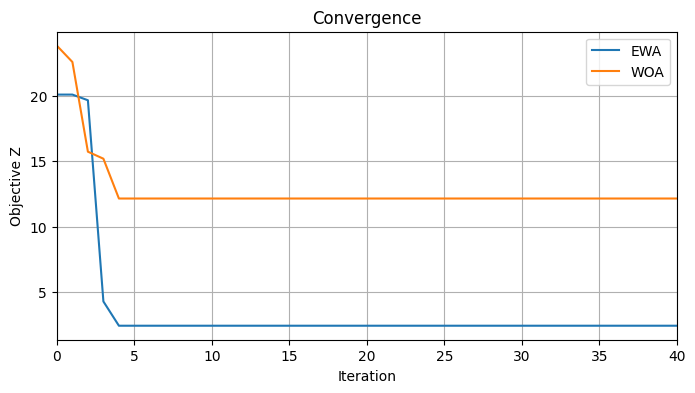

In [ ]:
N_tasks = 6; M = 4
ranks = np.random.rand(N_tasks); successors = {i:[] for i in range(N_tasks)}
for i in range(N_tasks):
    for j in range(N_tasks):
        if ranks[i] < ranks[j] and random.random() < 0.12:
            successors[i].append(j)
if all(len(s)==0 for s in successors.values()) and N_tasks>1: successors[0].append(1)

Qin_MB = np.random.uniform(10,100,N_tasks)
Qout_MB = np.random.uniform(1,10,N_tasks)
CC_cycles = np.random.uniform(100,500,N_tasks) * 1e6

res_ewa = EWA_algorithm(successors, Qin_MB, Qout_MB, CC_cycles, system_params, M, pop_size=12, iters=200)
res_woa = WOA_baseline_algorithm(successors, Qin_MB, Qout_MB, CC_cycles, system_params, M, pop_size=12, iters=200)

print("\nCorrected Results (scaled units):\n")
print("EWA -> Z={:.6e}, L={:.6e} s, E={:.6e} J, UC=${:.6e}".format(res_ewa["best_Z"], res_ewa["L"], res_ewa["E"], res_ewa["UC"]))
print("WOA -> Z={:.6e}, L={:.6e} s, E={:.6e} J, UC=${:.6e}".format(res_woa["best_Z"], res_woa["L"], res_woa["E"], res_woa["UC"]))


per = res_ewa["per_task"]
rows = []
for t in sorted(per.keys()):
    info = per[t]
    rows.append([t, info["location_idx"], info["start_time"], info["finish_time"], info["E_total"], info["UC"]])
df_tasks = pd.DataFrame(rows, columns=["task","location","start","finish","E_total","UC"])
display(df_tasks)


plt.figure(figsize=(8, 4))
plt.plot(res_ewa["history"], label="EWA")
plt.plot(res_woa["history"], label="WOA")
plt.xlim(0, 40)
plt.xlabel("Iteration")
plt.ylabel("Objective Z")
plt.title("Convergence")
plt.legend()
plt.grid(True)
plt.show()

